1. Make sure that b-splines are correct
    x. Check the code for obvious errors
    2. Write energy function that works with b-splines
    3. Check if the TPF and B-spline energies are the same
2. Write LinReg optimization function
3. Fit energy to an existing potential (e.g., Marinica)
4. Write Backfitting optimization function
5. Optimize stat. distance

In [12]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core
from statmechlib.forcefields import f_embed, f_dens, f_spline3

In [15]:
working = '../data/working'

In [16]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [17]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi, encoding='latin1')

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi, encoding='latin1')

len 50


In [18]:
targets['eos']['box'] = targets['eos']['box'][5:6]
targets['eos']['xyz'] = targets['eos']['xyz'][5:6]
targets['eos']['temp'] = targets['eos']['temp'][5:6]
targets['eos']['beta'] = targets['eos']['beta'][5:6]
targets['eos']['energy'] = targets['eos']['energy'][5:6]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][5:6]

In [19]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][0:5]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][0:5]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][0:5]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][0:5]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][0:5]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][0:5]

In [20]:
# targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
# targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
# targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
# targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
# targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
# stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]
# len(targets['eos_bcc']['energy']), len(stats_bspline['eos_bcc']['energy'])

In [21]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]

In [22]:
np.linspace(1.05, 4.25, 5)

array([1.05, 1.85, 2.65, 3.45, 4.25])

In [23]:
#edens_knots = list(np.linspace(1.05, 4.25, 5))
edens_knots = list(np.linspace(1.05, 4.25, 33))
#edens_knots = list(np.linspace(1.05, 5.25, 43))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [24]:
def Dbs(n, order, lo_bound=[], hi_bound=[]):
    """B-spline penalty matrix
    """
    
    pen = {0:[1.0],
           1:[1.0, -1.0],
           2:[1.0, -2.0, 1.0],
           3:[1.0, -3.0, 3.0, -1.0],
           4:[1.0, -4.0, 6.0, -4.0, 1.0]}   
    
    n_lo = len(lo_bound)
    n_hi = len(hi_bound)
    n_tot = n + n_lo + n_hi

    # Extended penalty matrix
    P = np.zeros((n_tot, n_tot), dtype=float)
    
    for i in range(n_tot-order):
        P[i, i:i+1+order] = pen[order]

    # Select inner part of the penalty matrix without constraints
    if n_hi > 0:
        D = np.copy(P[:,n_lo:-n_hi])
    else:
        D = np.copy(P[:,n_lo:])

    # Apply low and high constraints and sum them into 1D array
    C = np.zeros((n_tot), dtype=float)
    if n_lo > 0:
        C += P[:, :n_lo].dot(np.array(lo_bound))
    if n_hi > 0:
        C += P[:,-n_hi:].dot(np.array(hi_bound))
        
    #print('c',C)
    

    return D, C

In [25]:
def penalty_matrix(partitions):
    """Constructs b-spline penalty matrix for a given Hamiltonian
    
    The resulting matrix is constructed for 1 or more b-splines
    and may exclude designated parameters. 

    Parameters
    ----------
    n : int, len(self.coef_)
        number of parameters defining number of matrix columns
    order : int or list of ints
        order of the stiffness penalty. If list of values is provided,
        multiple b-splines will be penalized by the given orders.
    exclude : list of ints
        List of indices of parameters to be excluded from penalties
    bounds : list of lists
        For each b-spline, have a list of virtual 
    lower_bound : 1D array-like
        defines virtual parameter values below the fitting region
    upper_bound : 1D array-like
        defines virtual parameter values above the fitting region
        
    Returns
    -------
    Dsqr : ndarray, shape (n_coeffs, n_coeffs)
        Square of the penalty matrix
    """
    
    penalty_degree = {0, 1, 2, 3, 4}
    
    # Penalty matrices and vectors for Hamiltonian partitions
    D_parts = []
    C_parts = []
    for n_part, p_degree, scale, lo_bound, hi_bound in partitions:
        if p_degree is None: # no penalty
            dd = np.zeros((n_part, n_part), dtype=float)
            cc = np.zeros((n_part), dtype=float)
        elif p_degree in penalty_degree:
            dd, cc = Dbs(n_part, p_degree, lo_bound=lo_bound, hi_bound=hi_bound)
        else:
            raise ValueError("Unknown penalty: {}".format(ptype))
        if scale is not None:
            # scale coefficient penalty
            dd = np.diag(scale).dot(dd)

        D_parts.append(dd)
        C_parts.append(cc)
        #print(cc.shape, dd.shape)

    # Penalty matrix as a block diagonal from submatrices
    C = np.concatenate(C_parts)
    D = block_diag(*D_parts)
    #print('shapes', C.shape, D.shape)
    #print('C', C)
    
    # Square of penalty matrix needed in loss and its derivatives
    CC = C.dot(C)
    CD = 2.0*C.dot(D)
    DD = D.T.dot(D)
    #print('shapes2', CD.shape, DD.shape, CC.shape)

    return DD, CD, CC

In [26]:
len(pair_knots), len(edens_knots)

(43, 33)

In [27]:
# #scale = np.sqrt(np.logspace(-3, -0, len(pair_knots)))
# #[(s, k) for s, k in zip(scale, pair_knots)]


# # 3rd order penalty for larger distances
# partitions = []
# partitions.append([1, None, None, None, None]) # Embedding function - no penalty
# partitions.append([len(pair_knots), 3, scale, [], []])
# partitions.append([len(pair_knots), 3, None, [], []])
# partitions.append([len(edens_knots), 3, None, [], []])

# Dp3, Cp3, c3 = penalty_matrix(partitions)
# print(c3, Cp3, Dp3[:])

# # 2nd order penalty for larger distances
# partitions = []
# partitions.append([1, None, None, None, None]) # Embedding function - no penalty
# partitions.append([len(pair_knots), 3, None, [], []])
# partitions.append([len(edens_knots), 3, None, [], []])

# Dp2, Cp2, c2 = penalty_matrix(partitions)
# Dp3.shape, Dp2.shape

In [99]:
def make_input_matrices(target, stats, keytrj=None):
    """
    Creates input data for energy minimization with target as dependent variable and stats as independent.
    Assumes that all appropriate knots from stats have been selected, so it includes everything.
    """
    
    # matrix of independent variables (Embedding and B-spline coefficients)
    X0 = []
    X1 = []
    # vector of dependent variable (configurational energies)
    y = []
    # weights of individual trajectories
    weights = []
    # vector of inverse temperatures
    beta = []
    # bounds of trajectories in the overall design matrix
    bounds = []

    keys = list(target.keys())
    
    if keytrj is not None:
        keys = keytrj
    else:
        keys = list(target.keys())

    max_features = 0
    max_atoms = 0
    for key in keys:
        
        w = target[key]['weight']
        
        # eliminate trajectories with 0 weight
        if w == 0.0:
            continue

        lo_bound = len(y)
        
        # cycle over samples (configurations)

        for i, (config, energy, bb) in enumerate(zip(stats[key]['energy'], target[key]['energy'], target[key]['beta'])):
            
            # add energy
            y.append(energy)
            beta.append(bb)
            #weights.append(w)
            
            # create an array of independent variables
            x_vars = []
            
            # embedding for additive model
            #x_vars += [config[0][0], config[1][0]]

            # pair interactions b-spline stats. Adds a list of descriptors
            x_vars += list(0.5*config[2])
            
            # per atom edens b-spline stats. Adds an array (n_features, n_atoms)
            xn_vars = config[3]
            
            max_features = max(max_features, xn_vars.shape[0])
            max_atoms = max(max_atoms, xn_vars.shape[1])

            X0.append(x_vars)
            X1.append(xn_vars)
            
        bounds.append(slice(lo_bound, len(y)+1, 1))
        weights.append(w)
    
    # Additive features to a 2D array in X[0] 
    X0 = np.array(X0)
    X = [X0]
    
    # Non-additive features to a 3D array to be filled with density function statistics.
    # Organize the dimensions as (n_samples, n_atoms, n_features) so that dot product
    # between edens parameters and the array to compute density on individual atoms
    # is along the last (contiguous) dimension.
    X.append(np.zeros((len(X1), max_atoms, max_features), dtype=float))
    for i in range(len(X1)):
        X[1][i,:X1[i].shape[1],:] = X1[i].T
    
    y = np.array(y)
    
    assert len(y) == len(X[0]), "Shapes of y and X[0] do not match"
    assert len(y) == len(X[1]), "Shapes of y and X[1] do not match."
    

    return X, y, np.array(weights), np.array(beta), bounds


In [100]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [101]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 1.0
targets['eos']['weight'] = 1e-4
targets['eos_bcc']['weight'] = 0.5
targets['relax']['weight'] = 1000.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
targets['bcc_npt_langevin_300K']['weight'] = 2.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 1.0),
 ('liq_5000K', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 1000.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 2.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 0.0001),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('inf', 0.0),
 ('liq_3700K', 1.0),
 ('eos_bcc', 0.5),
 ('bain', 1.0)]

## Start with preoptimized parameters obtained from an additive model

In [102]:
def _tpf_to_bspline(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = len(penalty) -1 #order
    P = np.zeros((n_tot, n_tot), dtype=float)
    for i in range(n_tot):
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot:
                continue
            P[i, i+j-o] = p

    Pinv = np.linalg.inv(P.T)
    on = np.zeros(n_tot)
    on[-1] = 1.0
    return Pinv.dot(on)

In [103]:
edens_knots

[1.05,
 1.1500000000000001,
 1.25,
 1.35,
 1.4500000000000002,
 1.55,
 1.6500000000000001,
 1.75,
 1.85,
 1.9500000000000002,
 2.05,
 2.1500000000000004,
 2.25,
 2.35,
 2.45,
 2.55,
 2.6500000000000004,
 2.75,
 2.85,
 2.95,
 3.05,
 3.1500000000000004,
 3.25,
 3.3500000000000005,
 3.45,
 3.55,
 3.6500000000000004,
 3.75,
 3.8500000000000005,
 3.95,
 4.05,
 4.15,
 4.25]

In [104]:
#edens_coeffs = _tpf_to_bspline(len(edens_knots)*8+1)[8::8]
edens_coeffs = _tpf_to_bspline(len(edens_knots))
edens_coeffs

array([6.545e+03, 5.984e+03, 5.456e+03, 4.960e+03, 4.495e+03, 4.060e+03,
       3.654e+03, 3.276e+03, 2.925e+03, 2.600e+03, 2.300e+03, 2.024e+03,
       1.771e+03, 1.540e+03, 1.330e+03, 1.140e+03, 9.690e+02, 8.160e+02,
       6.800e+02, 5.600e+02, 4.550e+02, 3.640e+02, 2.860e+02, 2.200e+02,
       1.650e+02, 1.200e+02, 8.400e+01, 5.600e+01, 3.500e+01, 2.000e+01,
       1.000e+01, 4.000e+00, 1.000e+00])

In [105]:
b_preoptimized = [-3.66794696e-01,  4.06660863e-05,  4.55432192e+03,  3.81233526e+03,
        3.13457452e+03,  2.52103968e+03,  1.97173074e+03,  1.48664767e+03,
        1.06579047e+03,  7.09159114e+02,  4.16753580e+02,  1.88573853e+02,
        2.41578061e+01, -8.10170350e+01, -1.38288040e+02, -1.62295166e+02,
       -1.65451663e+02, -1.59888378e+02, -1.52679937e+02, -1.39059049e+02,
       -1.26124774e+02, -1.17219033e+02, -1.04327206e+02, -8.49009558e+01,
       -6.37485981e+01, -4.78623412e+01, -3.73348139e+01, -2.64590603e+01,
       -1.70659604e+01, -1.42414244e+01, -1.81406282e+01, -2.33807912e+01,
       -2.36385066e+01, -2.13661005e+01, -1.65315254e+01, -1.21306670e+01,
       -1.12774279e+01, -7.76031264e+00, -3.39803967e+00,  2.89809615e+00,
        5.21035097e+00,  1.70758787e+00,  8.85701451e-01,  1.27989801e+00,
        4.04308424e+00]

b_preoptimized = [
    -2.25564987e-01,  5.53471774e-05,  2.25541375e+03,  1.87319444e+03,
        1.52245661e+03,  1.20320028e+03,  9.15425419e+02,  6.59132036e+02,
        4.34320116e+02,  2.40989652e+02,  7.91406346e+01, -5.12269452e+01,
       -1.50194991e+02, -2.18597091e+02, -2.58686101e+02, -2.74078279e+02,
       -2.69861457e+02, -2.53982776e+02, -2.36493980e+02, -2.19246225e+02,
       -2.00531784e+02, -1.79009846e+02, -1.55497117e+02, -1.32694786e+02,
       -1.11402428e+02, -9.23235147e+01, -7.65468525e+01, -6.42617727e+01,
       -5.51831766e+01, -4.82737014e+01, -4.21720863e+01, -3.60158538e+01,
       -3.01743175e+01, -2.53604141e+01, -2.05869266e+01, -1.60165503e+01,
       -1.35593001e+01, -1.01858959e+01, -4.77285549e+00,  1.66505117e-01,
        9.71591796e-01, -1.81329966e+00, -3.46311117e+00, -3.49135492e+00,
       -1.67856521e+00
]

b_preoptimized = [
    -8.62142614e-01,  5.76185952e-04,  2.60678195e+03,  2.21333078e+03,
        1.85091762e+03,  1.51954248e+03,  1.21920534e+03,  9.49906210e+02,
        7.11645092e+02,  5.04421987e+02,  3.28236896e+02,  1.83089821e+02,
        6.89200289e+01, -1.49069956e+01, -7.02022078e+01, -1.00158659e+02,
       -1.09874134e+02, -1.07862489e+02, -1.04183739e+02, -1.00154277e+02,
       -9.34934573e+01, -8.31140399e+01, -7.01324477e+01, -5.73733960e+01,
       -4.53998654e+01, -3.46167922e+01, -2.61191305e+01, -2.03448417e+01,
       -1.72869419e+01, -1.60760416e+01, -1.53674281e+01, -1.43398461e+01,
       -1.31226750e+01, -1.20232162e+01, -1.02405430e+01, -8.15803964e+00,
       -7.81912304e+00, -6.22702947e+00, -2.10738403e+00,  1.68612203e+00,
        1.43191260e+00, -1.97196751e+00, -3.93012775e+00, -3.71908056e+00,
       -1.84930892e+00
]

b_preoptimized = [
    -6.46003130e-01,  7.85871765e-06,  3.15534395e+03,  2.72378871e+03,
        2.32544531e+03,  1.96031377e+03,  1.62839421e+03,  1.32968680e+03,
        1.06419176e+03,  8.31909330e+02,  6.32839739e+02,  4.66983207e+02,
        3.34151254e+02,  2.32472926e+02,  1.57536663e+02,  1.05204064e+02,
        7.31617109e+01,  5.38645680e+01,  3.79930283e+01,  2.99543510e+01,
        2.32950333e+01,  1.64820307e+01,  1.47930684e+01,  1.67083553e+01,
        2.10947563e+01,  2.51714433e+01,  2.78784388e+01,  3.06791356e+01,
        2.94699342e+01,  2.42869002e+01,  1.85732752e+01,  1.30728769e+01,
        7.63359417e+00,  3.78059718e+00,  3.76799965e+00,  2.91392821e+00,
       -1.27624188e+00, -5.36468372e-01,  2.67239460e+00,  4.31532027e+00,
        3.50631260e+00,  1.49947121e+00, -1.21790753e+00, -1.15964733e+00,
        1.73779893e+00
]
b_preoptimized = [-1.48890852e+00, -1.89656567e-05,  4.11114713e+03,  3.58184960e+03,
        3.09167632e+03,  2.64062730e+03,  2.22870265e+03,  1.85590254e+03,
        1.52222715e+03,  1.22767670e+03,  9.72251390e+02,  7.55951430e+02,
        5.78574263e+02,  4.38099916e+02,  3.29632933e+02,  2.48189331e+02,
        1.90466442e+02,  1.47865787e+02,  1.11018748e+02,  8.52153708e+01,
        6.34305903e+01,  4.32409477e+01,  3.03354436e+01,  2.31374883e+01,
        2.03110469e+01,  1.87632212e+01,  1.72027393e+01,  1.73033627e+01,
        1.47715464e+01,  8.99940928e+00,  3.38195294e+00, -1.53465249e+00,
       -5.89727312e+00, -8.08220252e+00, -6.00115971e+00, -4.52578517e+00,
       -6.76564604e+00, -4.59814411e+00, -2.04685166e-01,  2.49006554e+00,
        2.45383322e+00,  7.47619823e-01, -1.59126609e+00, -1.18099220e+00,
        1.83761329e+00]

In [106]:
# Rescale initial parameters
Ae, Be = b_preoptimized[: 2]
edens_coeffs *= Ae**2
Be /= Ae**4
Ae = -1.0
b_init = np.array([Be] + list(b_preoptimized[2:]) + list(edens_coeffs))
b_init

array([-3.85918701e-06,  4.11114713e+03,  3.58184960e+03,  3.09167632e+03,
        2.64062730e+03,  2.22870265e+03,  1.85590254e+03,  1.52222715e+03,
        1.22767670e+03,  9.72251390e+02,  7.55951430e+02,  5.78574263e+02,
        4.38099916e+02,  3.29632933e+02,  2.48189331e+02,  1.90466442e+02,
        1.47865787e+02,  1.11018748e+02,  8.52153708e+01,  6.34305903e+01,
        4.32409477e+01,  3.03354436e+01,  2.31374883e+01,  2.03110469e+01,
        1.87632212e+01,  1.72027393e+01,  1.73033627e+01,  1.47715464e+01,
        8.99940928e+00,  3.38195294e+00, -1.53465249e+00, -5.89727312e+00,
       -8.08220252e+00, -6.00115971e+00, -4.52578517e+00, -6.76564604e+00,
       -4.59814411e+00, -2.04685166e-01,  2.49006554e+00,  2.45383322e+00,
        7.47619823e-01, -1.59126609e+00, -1.18099220e+00,  1.83761329e+00,
        1.45092740e+04,  1.32656219e+04,  1.20951259e+04,  1.09955690e+04,
        9.96473437e+03,  9.00040524e+03,  8.10036471e+03,  7.26239595e+03,
        6.48428210e+03,  

## SD matching
**Loss function**

In [107]:
def energy(params, X):
    """ Configurational energy of an EAM model.
    """
    
    n_edens = X[1].shape[-1]
    
    # Pair energy
    energy = X[0].dot(params[1:-n_edens])
    
    # calculates an (n_samples, n_atoms) matrix of atomic densities
    edens = X[1].dot(params[-n_edens:])

    # Manybody energy: A*sum(dens**0.5) + B*sum(dens**2)
    # Here we set A to -1 to eliminate colinearity
    energy += -1.0*np.sum(np.sqrt(edens), axis=1)
    energy += params[0]*np.sum(edens**2, axis=1)
        
    return energy

In [108]:
def loss_energy(params, X, y, weights):
    """Total energy loss (least squares)"""

    du = y - energy(params, X)
    loss = du.T.dot(np.diag(weights)).dot(du)

    return loss

In [147]:
def loss_sd2(params, X, y, weights, bounds, beta):
    """Statistical distance loss"""

    beta_du = beta*(y - energy(params, X))

    # statistical distance
    # * divide system into individual trajectories (use bounds)
#     loss = 0.0
#     for ib, x_lo, x_hi in enumerate(bounds):
#         uuu = beta_du[x_lo:x_hi]
#         uuu -= np.mean(uuu)
#         eee = np.exp(-uuu)
#         ge = np.log(np.mean(eee))              # -beta*dF
#         cb = np.mean(np.exp(-0.5*(uuu + ge)))  # Bhattacharyya coefficient
#         loss += weights[ib]*np.arccos(cb)**2   # statistical distance

    loss = 0.0
    for ib, bound_slice in enumerate(bounds):
        du = beta_du[bound_slice]             # du (view of the original beta*du)
        du_ave = np.mean(du)                   # average du
        exp_duh = np.exp(-0.5*(du - du_ave))     # exp[-beta*du/2]
        cb = np.mean(exp_duh)                    # cb = <exp[-beta*du/2]>
        cb /= np.sqrt(np.mean(exp_duh**2))       # Bhattacharyya coeff.: cb/exp[-beta*dF/2]
        print('loss cb', cb)
        loss += weights[ib]*np.arccos(cb)**2   # statistical distance

    return loss

In [148]:
def loss_diff_penalty(params, penalty_mat, alpha):
    """Difference penalty loss for B-splines"""
    return 0.5*alpha*params.T.dot(penalty_mat).dot(params)

In [149]:
#def loss_total(params, X, y, weights, args=None):

In [150]:
def loss_energy_penalized(params, X, y, weights, penalty_mat, alpha):
    """Total energy loss with difference penalty"""

    loss = loss_energy(params, X, y, weights)
    loss_diff = loss_diff_penalty(params, penalty_mat, alpha)
    
    print(loss + loss_diff, loss, loss_diff)

    return loss + loss_diff

In [151]:
def loss_sd2_penalized(params, X, y, weights, bounds, beta, penalty_mat, alpha):
    """Total sd2 loss with difference penalty"""
    
    loss = loss_sd2(params, X, y, weights, bounds, beta)
    loss_diff = loss_diff_penalty(params, penalty_mat, alpha)

    print(loss + loss_diff, loss, loss_diff)

    return loss + loss_diff

**Jacobian calculation**

In [152]:
def gradient_energy(params, X):
    """Calculates gradient of energy with respect to parameters.
    
    Returns
    -------
    grad : ndarray, shape (N, p)
    """

    # electronic densities
    n_edens = X[1].shape[-1]
    edens = X[1].dot(params[-n_edens:])
    
    with np.errstate(divide='ignore'):
        # (-1) is there for the constant parameter value
        tmp = np.nan_to_num(-1.0/(2.0*np.sqrt(edens)) + 2.0*params[0]*edens)

    grad = np.empty((X[0].shape[0], len(params)), dtype=float)
    grad[:, 1:-n_edens] = X[0]                                 # pair
    grad[:, 0] = np.sum(edens**2, axis=1)                      # embed
    grad[:, -n_edens:] = np.sum(tmp[:, :, None]*X[1], axis=1)  # edens

    return grad

In [153]:
def jacobian_energy(params, X, y, weights):
    """Calculates jacobian of energy loss function"""
    
    du = y - energy(params, X)
    grad = gradient_energy(params, X)
    jac = -2.0*grad.T.dot(np.diag(weights)).dot(du)
    
    return jac

In [154]:
def jacobian_sd2(params, X, y, weights, bounds, beta):
    """Calculates jacobian of statistical distance loss function"""
    
    # use reduced units beta*energy throughout
    beta_du = beta*(y - energy(params, X))                    # shape (N,)
    grad_beta_du = beta[:, np.newaxis]*gradient_energy(params, X)  # shape (N, p)

    jac = np.zeros((len(params)), dtype=float)
    
    for ib, bound_slice in enumerate(bounds):
        du = beta_du[bound_slice]               # du (view of the original beta*du)
        du_ave = np.mean(du)                    # average du
        exp_duh = np.exp(-0.5*(du - du_ave))    # exp[-beta*du/2]
        exp_du = exp_duh**2                     # exp[-beta*du]
        exp_dfi = 1.0/np.mean(exp_du)           # 1/<exp[-beta*du]> = exp(beta*dF)
        cb = np.mean(exp_duh)*np.sqrt(exp_dfi)  # Bhattacharyya coefficient
        print('jac cb', cb)

        # Gradient of free energy (with respect to model parameters)
        # grad_df = <grad_beta_du * exp[-beta*du]> / <exp[-beta*du]>
        grad_du = grad_beta_du[bound_slice]
        grad_df = np.mean(grad_du*exp_du[:, None], axis=0)*exp_dfi
        
        # Gradient of the Bhattacharyya coeff. shape (p,)
        # -1/2 * <exp[-beta*du/2] * (grad_beta_du - grad_df)> / exp[-beta*df/2]
        grad_cb = np.mean((grad_du - grad_df)*exp_duh[:, None], axis=0)
        grad_cb *= -0.5*np.sqrt(exp_dfi)
        
        # Jacobian
        jac += 2.0*weights[ib]*np.arccos(cb)/np.sqrt(1.0 - cb**2)*grad_cb
    
    return jac

In [155]:
def jacobian_diff_penalty(params, penalty_mat, alpha):
    """Jacobian contribution of the B-spline difference penalty"""
    return alpha*penalty_mat.dot(params)

In [156]:
def jacobian_energy_penalized(params, X, y, weights, penalty_mat, alpha):
    jac = jacobian_energy(params, X, y, weights)
    jac += jacobian_diff_penalty(params, penalty_mat, alpha)
    return jac

In [157]:
def jacobian_sd2_penalized(params, X, y, weights, bounds, beta, penalty_mat, alpha):
    jac = jacobian_sd2(params, X, y, weights, bounds, beta)
    jac += jacobian_diff_penalty(params, penalty_mat, alpha)
    return jac

In [158]:
b_init = np.array([ 2.15039091e-04,  2.39583735e+03,  2.06488126e+03,  1.75850009e+03,
        1.47669328e+03,  1.21946137e+03,  9.86807244e+02,  7.78732277e+02,
        5.95235136e+02,  4.36312752e+02,  3.01965422e+02,  1.92143407e+02,
        1.06323715e+02,  4.32286398e+01,  1.72198297e+00, -1.96841385e+01,
       -2.78317473e+01, -3.23254722e+01, -3.12921167e+01, -2.87148042e+01,
       -2.60682284e+01, -1.97964742e+01, -1.05483048e+01, -6.91446618e-02,
        9.80600312e+00,  1.81497062e+01,  2.44762828e+01,  2.59117419e+01,
        2.29637333e+01,  1.81441067e+01,  1.21450205e+01,  5.90203739e+00,
        1.68875805e+00,  9.29697477e-02, -1.94775719e+00, -5.14555395e+00,
       -3.34783032e+00, -8.46442656e-02,  1.78474570e+00,  2.09831830e+00,
        1.03026931e+00, -1.72104174e+00, -1.47551091e+00,  1.24247691e+00,
        5.33214477e+03,  4.84692005e+03,  4.39079702e+03,  3.96377336e+03,
        3.56584285e+03,  3.19699904e+03,  2.85723735e+03,  2.54655515e+03,
        2.26495051e+03,  2.01241801e+03,  1.78894026e+03,  1.59440068e+03,
        1.42843437e+03,  1.29019037e+03,  1.17803243e+03,  1.08943679e+03,
        1.02111648e+03,  9.68845779e+02,  9.28176227e+02,  8.94286865e+02,
        8.62207834e+02,  8.27644481e+02,  7.87304159e+02,  7.39142252e+02,
        6.82278709e+02,  6.16822322e+02,  5.43748998e+02,  4.64539444e+02,
        3.81083191e+02,  2.95624418e+02,  2.10263603e+02,  1.26317261e+02,
        4.42271600e+01])

In [161]:
alpha = 0.5

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, np.ones((len(pair_knots))), [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*2.0, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)
    
    penalty_type = 'sd2'  #'energy'
    if penalty_type == 'energy':
        
        # assign weights to individual configurations
        weight_config = np.empty((len(y),), dtype=float)
        for i_trj, bound_slice in enumerate(bounds):
            weight_config[bound_slice] = weight[i_trj]

        loss = loss_energy_penalized
        jac = jacobian_energy_penalized
        args = (X, y, weight_config, Dp3, alpha)

    elif penalty_type == 'sd2':
        loss = loss_sd2_penalized
        jac = jacobian_sd2_penalized
        alpha *= 1e-4
        args = (X, y, weight, bounds, beta, Dp3, alpha)
    
    results.append(minimize(loss, b_init, args=args, jac=jac, options={'maxiter':10000}))

    #results.append(minimize(loss_energy_penalized, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian_energy_penalized, options={'maxiter':10000}))
    

0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [[  0.   0.   0. ...   0.   0.   0.]
 [  0.   1.  -3. ...   0.   0.   0.]
 [  0.  -3.  10. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  76. -48.  12.]
 [  0.   0.   0. ... -48.  40. -12.]
 [  0.   0.   0. ...  12. -12.   4.]]
jac cb 0.9999999762325616
jac cb 0.9999999878816562
jac cb 0.9999998671781799
jac cb 0.9999999896135872
jac cb 0.9999999830114554
jac cb 0.9999999834727115
jac cb 0.9999999903105409
jac cb 0.9999999636924999
jac cb 0.9973773074119214
jac cb 0.8294243769053719
jac cb 0.9999844325652839
jac cb 0.9999854543655419
jac cb 0.9999999910969168
loss cb 0.9999999762325618
loss cb 0.9999999878816562
loss cb 0.99999986717818
loss cb 0.9999999896135872
loss cb 0.9999999830114553
loss cb 0.9999999834727115
loss cb 0.999999990310541
loss cb 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in square
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in square
  
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


jac cb nan
jac cb nan
jac cb nan
jac cb 0.0649569802461631
jac cb 0.08638684255814262
jac cb 0.08543576590239012
jac cb 0.07095111433173046
jac cb 0.10425728783176044
jac cb nan
jac cb nan
jac cb nan
jac cb 0.0
jac cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb 0.0
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
nan nan 0.02333694183751314
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb 0.0
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
nan nan 0.02332682733405489
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
nan nan 70574605.75766897
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
nan nan 1129204567.9057174
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
nan nan 18067316590.673843
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
loss cb nan
loss cb nan

jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
nan nan 2.290306310350046e+40
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
nan nan 3.664490096560073e+41
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
jac cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
loss cb nan
nan nan 5.863184154496117e+42
jac cb nan
ja

KeyboardInterrupt: 

In [121]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'bain',
 'relax']

[]

In [122]:
results[-1]['x']

IndexError: list index out of range

In [123]:
#b_all = b_final
b_all = results[-1]['x']
b_all

IndexError: list index out of range

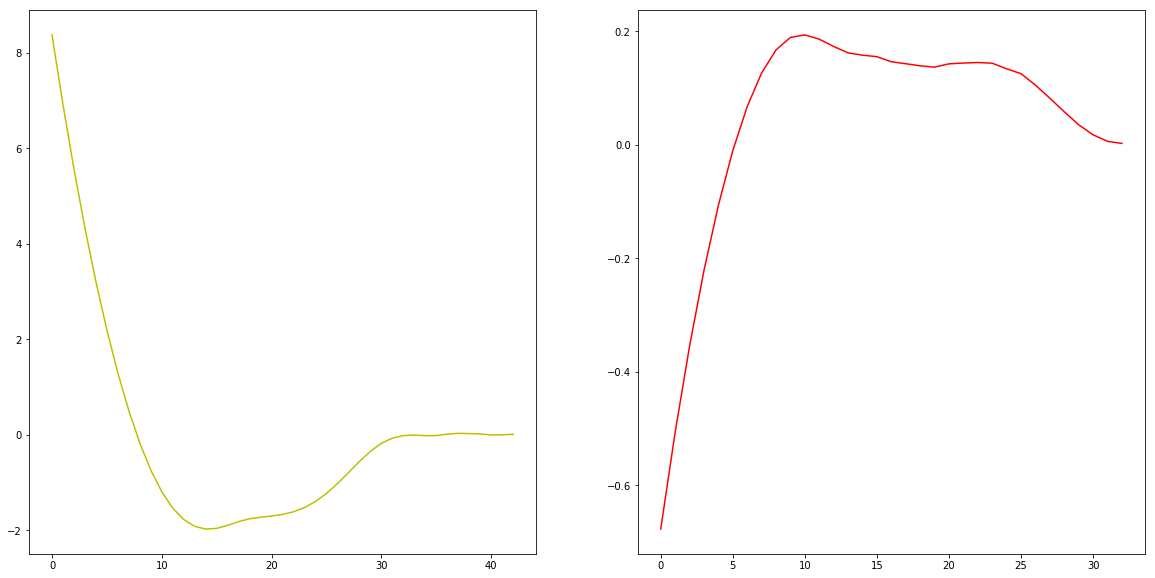

In [85]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
# plt.plot(np.array(b_weight9[2:])*(6*0.1**3) , 'g')
# plt.plot(np.array(b_weight8[2:])*(6*0.1**3) , 'b')
# plt.plot(np.array(b_weight7[2:])*(6*0.1**3) , 'm')
axs[0].plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'y')
#axs[0].set_xlim(10,)
#axs[0].set_ylim(-1.0,-.5)

axs[1].plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'r')

# plt.ylim(-2,10)
# plt.hlines(0, 0, 42)
# plt.legend()


# rr = np.linspace(1.3, 5.65, 436)

# plt.plot(rr, [make_bspline(b_all[1:1+len(pair_knots)], p_knot, r) for r in rr])
# plt.xlim(1.3,)
# plt.ylim(-1.5,0.2)
# plt.xlim(rr[0], rr[-1])
# plt.hlines(0.0, rr[0], rr[-1])

In [86]:
bounds

[[0, 200],
 [200, 346],
 [346, 472],
 [472, 708],
 [708, 841],
 [841, 977],
 [977, 1176],
 [1176, 1267],
 [1267, 1389],
 [1389, 1390],
 [1390, 1395],
 [1395, 1407],
 [1407, 1413]]

[-1094.029, -1094.411, -1094.256, -1094.017, -1093.66, -1093.401, -1093.255, -1093.177, -1093.173, -1093.356, -1093.468, -1093.633, -1093.825, -1093.829, -1093.77, -1093.689, -1093.525, -1093.512, -1093.393, -1093.21, -1093.113, -1093.247, -1093.334, -1093.536, -1093.722, -1093.874, -1093.83, -1093.571, -1092.953, -1092.416, -1092.216, -1092.425, -1092.981, -1093.672, -1094.312, -1094.983, -1095.312, -1095.448, -1095.52, -1095.46, -1095.118, -1094.321, -1093.357, -1092.63, -1092.265, -1092.339, -1092.743, -1093.529, -1094.314, -1095.167, -1095.842, -1096.281, -1096.372, -1096.295, -1095.956, -1095.427, -1094.703, -1093.698, -1092.669, -1091.528, -1090.546, -1089.728, -1089.063, -1088.54, -1088.362, -1088.23, -1088.339, -1088.654, -1088.881, -1088.971, -1088.965, -1089.008, -1089.089, -1089.432, -1089.654, -1089.935, -1090.488, -1090.757, -1090.82, -1090.787, -1090.582, -1090.239, -1090.018, -1089.881, -1089.853, -1089.689, -1089.509, -1089.066, -1088.574, -1088.073, -1087.742, -1087.49

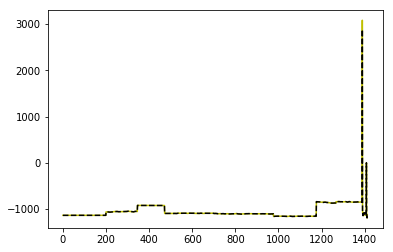

In [92]:
plt.plot(energy(b_all, X), 'y')
#plt.plot(X.dot(b_weight4), 'm')
plt.plot(y, 'k--')
# plt.xlim(len(X)-7,len(X)-1)
# plt.ylim(-1200,-1120)

#print(list(y[382:389]), list(X.dot(b_0)[382:389]))
# print([round(z, 3) for z in X.dot(b_weight9)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight8)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight7)[-6:]])


#print(bounds[index][0])
#print([round(z, 3) for z in X.dot(b_all)[-6:]])
print([round(z, 3) for z in energy(b_all, X)[bounds[3][0]:bounds[3][1]]])
print([round(z, 3) for z in y[bounds[3][0]:bounds[3][1]]])

#print([round(z, 3) for z in y[-6:]])

In [93]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [94]:
for i, stat in enumerate(stats_list[-1:]):
    Xallx, yallx, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)
    #X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)


In [96]:
energy(b_all, Xallx)[:-6]

array([-1134.55819858, -1134.52220946, -1134.45769291, ...,
       -1094.55507237, -1085.92991918, -1070.57998818])

In [97]:
sys.getsizeof(Xallx[1])/sys.getsizeof(Xallx[0]), sys.getsizeof(b_all)

(329.92519537914114, 712)

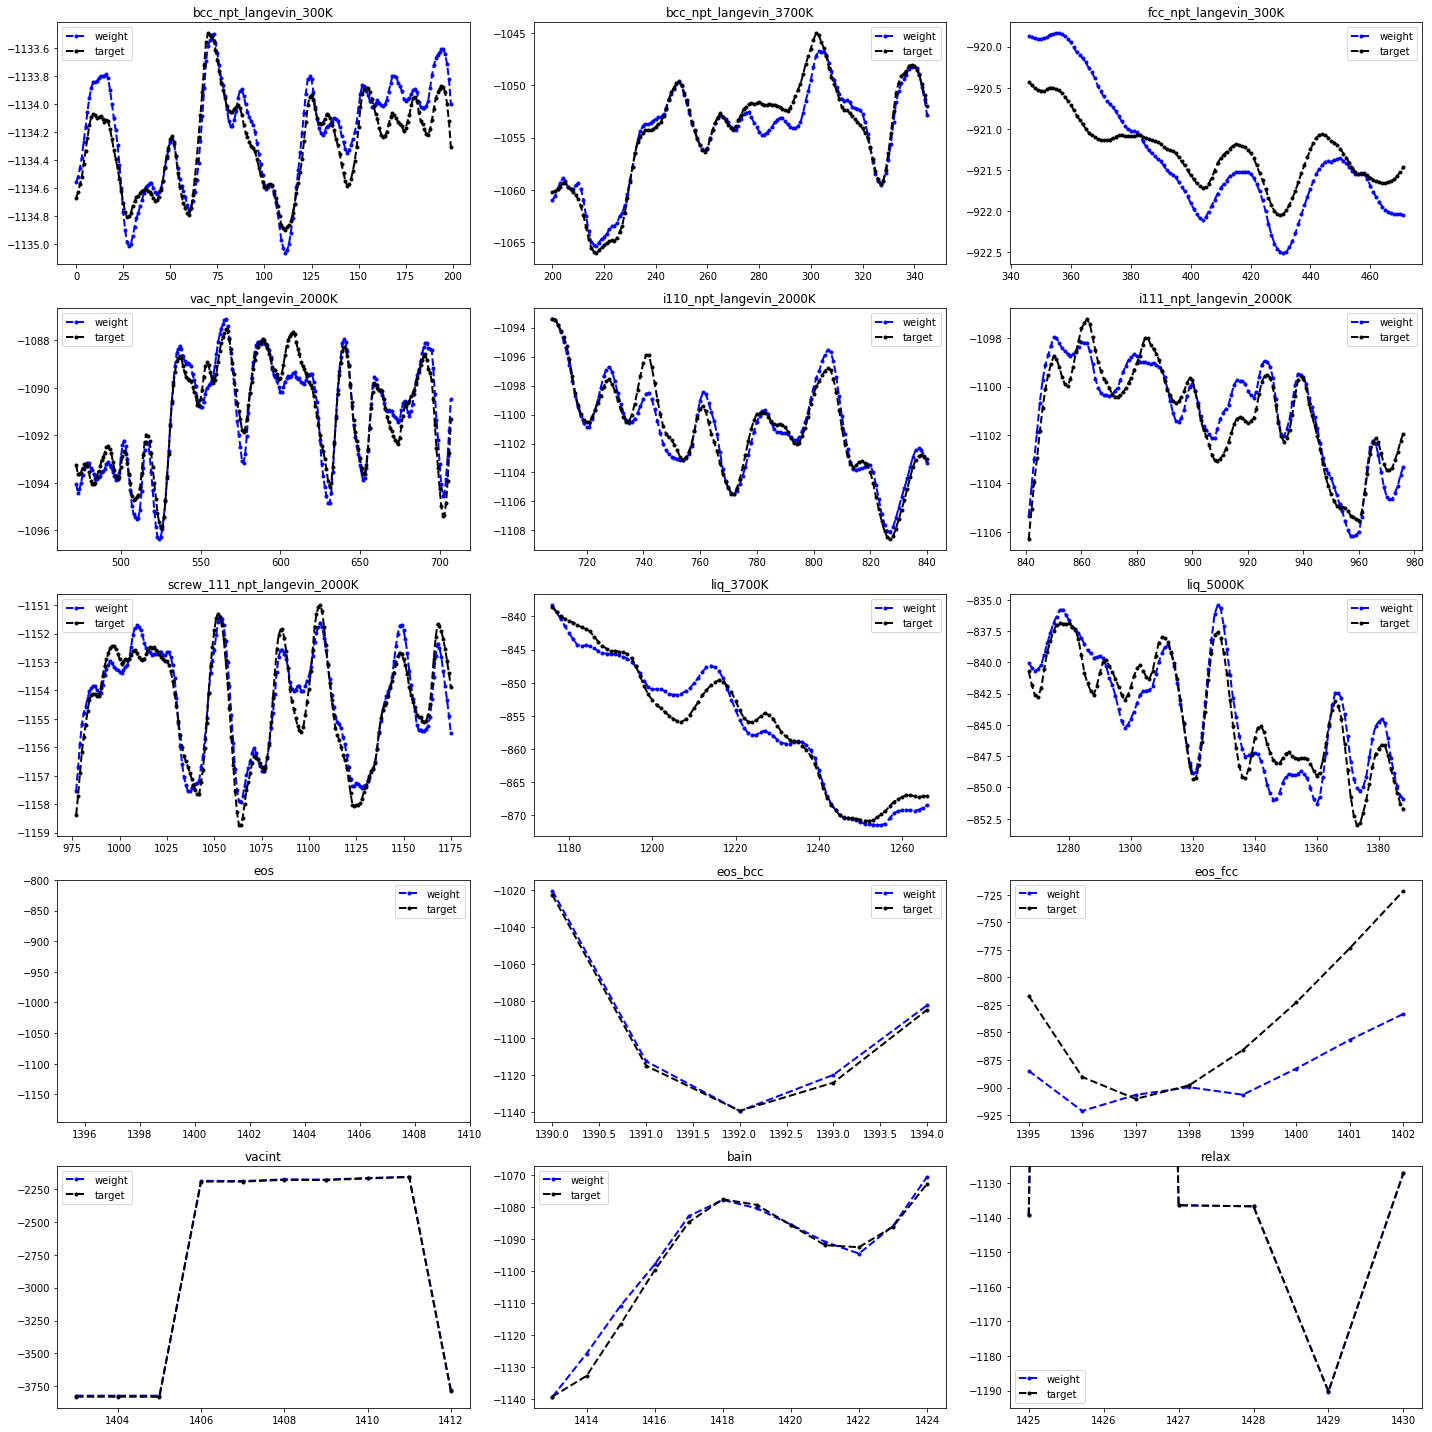

In [98]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(bounds[k][0], bounds[k][1]))

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
    axes[i,j].plot(rr, energy(b_all, Xallx)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight9)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yallx[bounds[k][0]:bounds[k][1]], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
    if trj == 'eos':
        axes[i,j].set_ylim(-1195, -800)
        axes[i,j].set_xlim(1395,1410)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [816]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi)

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

len 50


In [817]:
len(stats_tpf['relax']['energy'][0][2]), len(stats_bspline['relax']['energy'][0][2])

(50, 46)

In [818]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [819]:
mb_knots = list(np.linspace(3.75, 5.25, 16))
pair_knots = list(np.linspace(1.05, 5.25, 43))
#pair_knots = list(np.linspace(2.05, 5.25, 33))

print(mb_knots)
print(pair_knots)

# Select knots for optimization
# cycle over knots of selected models
stats_list = []
for knot in mb_knots:
    edens_knots = [knot]
    stats = downselect(stats_bspline, pair_knots, edens_knots)
    stats_list.append(stats)

[3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [820]:
for i, stat in enumerate(stats_list[-1:]):
    Xall, yall, weights, beta, bounds = make_sd_matrices(targets, stat, keytrj=tkeys)

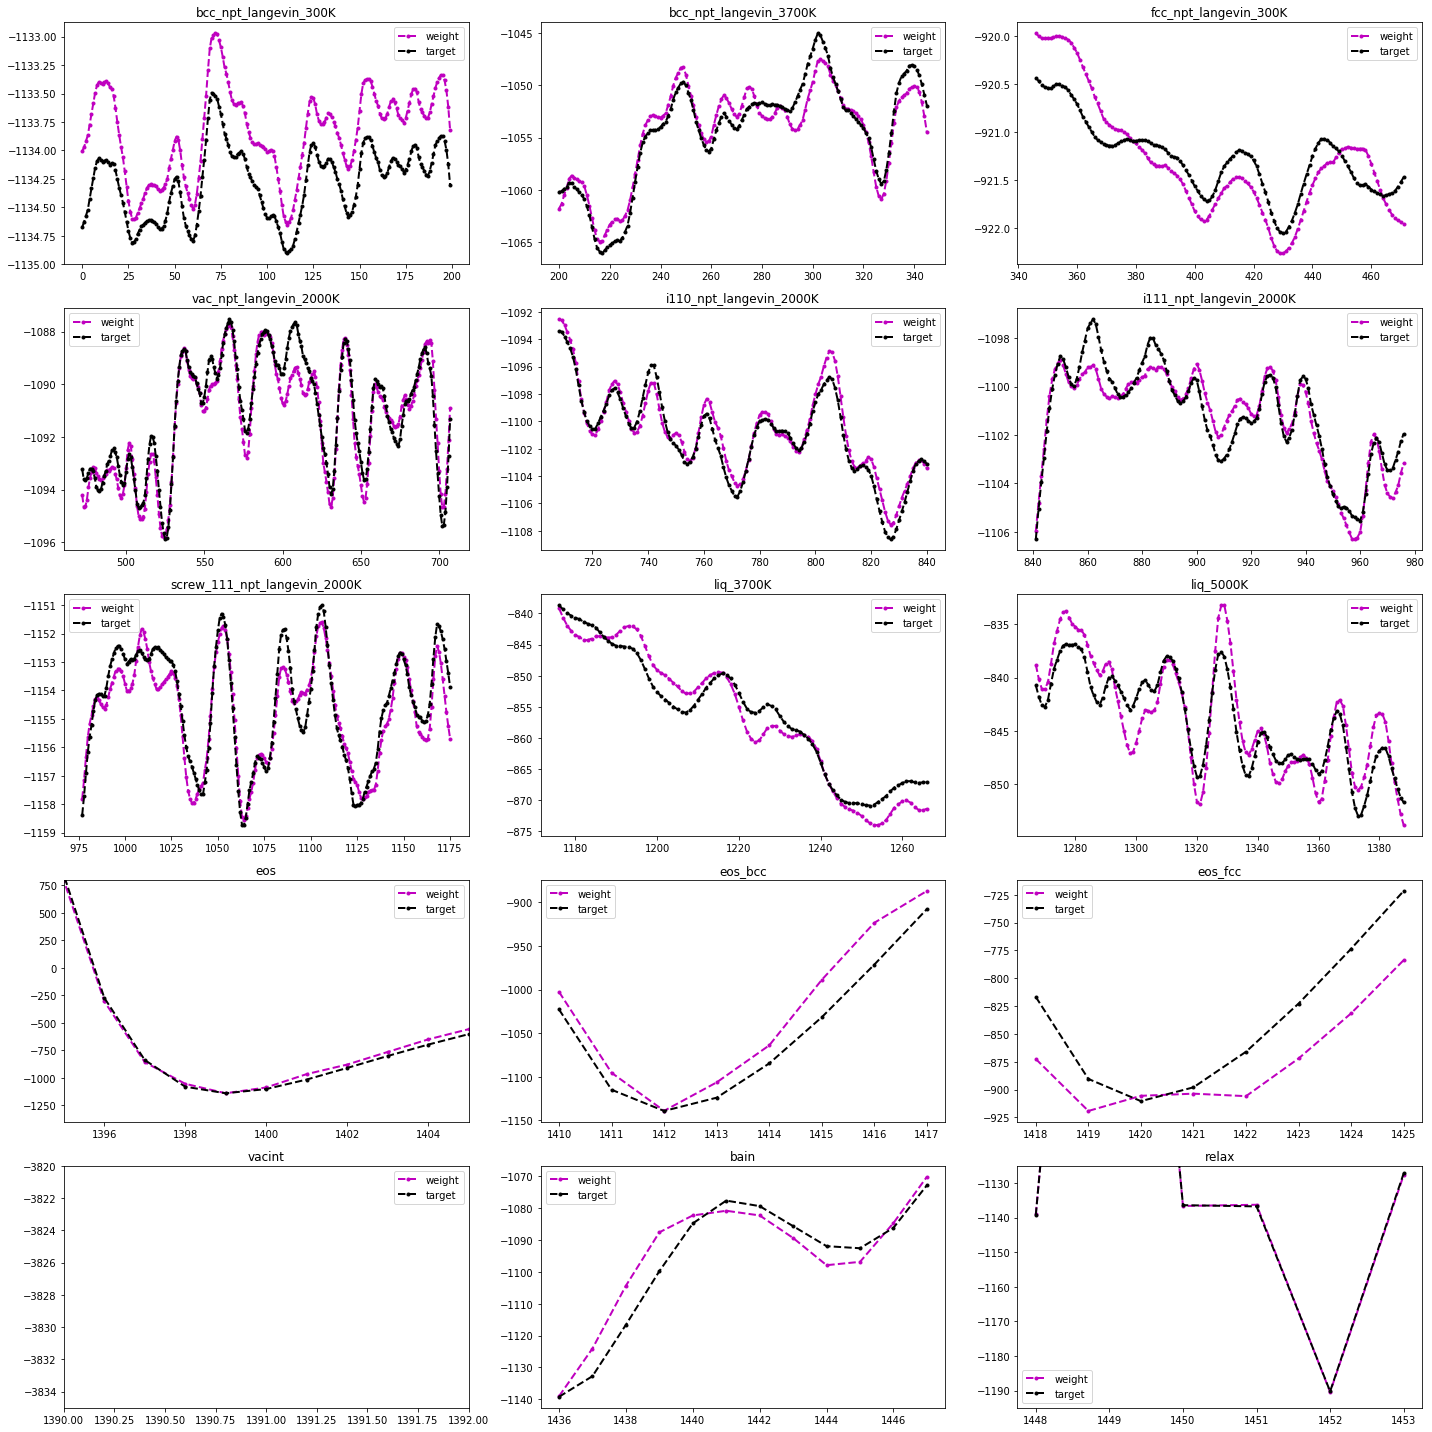

In [822]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(bounds[k][0], bounds[k][1]))

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight7)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
    axes[i,j].plot(rr, Xall.dot(b_all)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yall[bounds[k][0]:bounds[k][1]], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3820)
        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1400, 800)
        axes[i,j].set_xlim(1395,1405)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [504]:
p_knots = np.array(pair_knots)+0.4
p_knots

array([1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15, 2.25, 2.35, 2.45,
       2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15, 3.25, 3.35, 3.45, 3.55,
       3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65,
       4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65])

In [505]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [506]:
M = _bspline_coeffs_to_tpf(43)

In [507]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[2:]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.22824426e+03  3.54009480e+03  2.91119261e+03  2.34153772e+03
  1.83113026e+03  1.37997039e+03  9.88058321e+02  6.55394274e+02
  3.81978459e+02  1.67811053e+02  1.24862009e+01 -8.79627304e+01
 -1.43545176e+02 -1.67016514e+02 -1.68316234e+02 -1.58859588e+02
 -1.52245978e+02 -1.41522891e+02 -1.31799084e+02 -1.24427156e+02
 -1.07866113e+02 -8.29740112e+01 -6.06836589e+01 -4.81849563e+01
 -4.36744378e+01 -3.91472388e+01 -3.22134949e+01 -2.58537638e+01
 -2.26912671e+01 -2.12961404e+01 -2.06873517e+01 -1.86526528e+01
 -1.45559864e+01 -1.10689543e+01 -8.78888460e+00 -5.32464713e+00
 -1.32322585e+00  9.00599115e-01  1.19455876e+00  1.38108240e+00
 -4.40635093e-01 -1.37195754e+00 -1.22719835e+00]
[ 4.22824426e+03 -1.33728823e+04  1.41202790e+04 -4.97564098e+03
  9.10758972e-05  5.38825989e-05  3.86238098e-05  5.24520874e-06
 -2.62260437e-06 -3.64780426e-05 -4.06030059e-01 -3.56078100e+00
 -6.04279995e+00 -2.74594337e+00  2.81588787e+00 -1.47576168e+00
 -2.18415010e+00  2.05519152e+01 -1.2061

In [508]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
len(tpf_coeff), len(p_knot)

(47, 47)

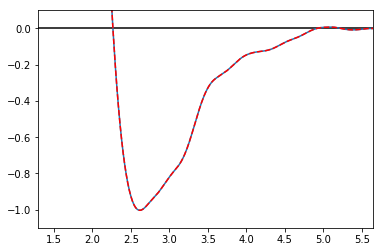

In [517]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[2:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[2:], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-1.1,0.1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [513]:
tpf_coeff

array([ 4.22824426e+03, -1.33728823e+04,  1.41202790e+04, -4.97564098e+03,
        9.10758972e-05,  5.38825989e-05,  3.86238098e-05,  5.24520874e-06,
       -2.62260437e-06, -3.64780426e-05, -4.06030059e-01, -3.56078100e+00,
       -6.04279995e+00, -2.74594337e+00,  2.81588787e+00, -1.47576168e+00,
       -2.18415010e+00,  2.05519152e+01, -1.20612704e+01,  3.75615722e+00,
        1.28935941e+01, -1.23990495e+01, -1.00747538e+01,  3.74290898e+00,
        8.99336571e+00,  6.20139912e+00, -5.61500046e+00, -5.37042186e+00,
        3.57335970e-01,  4.05308592e+00, -4.48832229e-01,  1.23121627e+00,
       -1.57619130e+00, -3.30765875e+00,  2.07427372e+00,  2.98845802e+00,
       -3.03811395e+00, -1.66779622e+00,  2.16251113e+00,  1.97469831e+00,
       -3.72323444e+00,  4.79944132e+00, -2.71294960e+00, -1.79329082e-01,
       -2.31599501e+00,  3.53683585e+00, -1.22719835e+00])

In [516]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))

print('edens') 
for c, k in zip([1.0], [5.25]):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
        
print('embed')
#print(-4.42166597e-01,  1.12818607e-04)
print(-4.49779872e-01,  1.09664665e-04)

pair
+4228.2442627d0*(1.05d0 - r)**3*H(1.05d0 - r)
-13372.8822546d0*(1.15d0 - r)**3*H(1.15d0 - r)
+14120.2789984d0*(1.25d0 - r)**3*H(1.25d0 - r)
-4975.64097977d0*(1.35d0 - r)**3*H(1.35d0 - r)
+9.10758972168e-05d0*(1.45d0 - r)**3*H(1.45d0 - r)
+5.3882598877e-05d0*(1.55d0 - r)**3*H(1.55d0 - r)
+3.86238098145e-05d0*(1.65d0 - r)**3*H(1.65d0 - r)
+5.24520874023e-06d0*(1.75d0 - r)**3*H(1.75d0 - r)
-2.62260437012e-06d0*(1.85d0 - r)**3*H(1.85d0 - r)
-3.64780426025e-05d0*(1.95d0 - r)**3*H(1.95d0 - r)
-0.406030058861d0*(2.05d0 - r)**3*H(2.05d0 - r)
-3.56078100204d0*(2.15d0 - r)**3*H(2.15d0 - r)
-6.04279994965d0*(2.25d0 - r)**3*H(2.25d0 - r)
-2.74594336748d0*(2.35d0 - r)**3*H(2.35d0 - r)
+2.8158878684d0*(2.45d0 - r)**3*H(2.45d0 - r)
-1.4757616818d0*(2.55d0 - r)**3*H(2.55d0 - r)
-2.18415009975d0*(2.65d0 - r)**3*H(2.65d0 - r)
+20.5519151688d0*(2.75d0 - r)**3*H(2.75d0 - r)
-12.061270386d0*(2.85d0 - r)**3*H(2.85d0 - r)
+3.75615721941d0*(2.95d0 - r)**3*H(2.95d0 - r)
+12.893594116d0*(3.05d0 - r)**3*H(3

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']

Parameters given to Yuri:

Embedding:
-4.42166597e-01,  1.12818607e-04,
Pair potential coefficients: Knots ending at 5.65 with steps of 0.1 A:

4.51698420e+03,  3.75910139e+03, 3.06924350e+03,  2.44738802e+03,  1.89346739e+03,  1.40738478e+03,
9.89029865e+02,  6.38294633e+02,  3.55089127e+02,  1.39357269e+02,
       -9.60824592e+00, -9.86104306e+01, -1.44135463e+02, -1.65813774e+02,
       -1.73239670e+02, -1.65893890e+02, -1.60198554e+02, -1.46418160e+02,
       -1.35762684e+02, -1.25923736e+02, -1.10532902e+02, -8.90260796e+01,
       -6.86880677e+01, -5.45283774e+01, -4.52604866e+01, -3.77851927e+01,
       -3.19692325e+01, -2.76892221e+01, -2.45864649e+01, -2.09702658e+01,
       -1.96949536e+01, -2.16298673e+01, -1.49970585e+01, -9.26360379e+00,
       -1.22233430e+01, -5.85168131e+00,  1.60207091e+00,  3.86904582e+00,
       -2.36332511e+00,  2.69685169e+00, -1.92552950e+00, -5.24093457e-01,
        1.38798423e-01